<a href="https://colab.research.google.com/github/CompPsychology/psych290_colab_public/blob/main/notebooks/week-08/W8_Tutorial_14_DLATK_machine_learning_(dla_tutorial%2Csvitlana).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 14 - Machine learning prediction (regression & classification) (2025-05)

✋🏻✋🏻 NOTE - You need to create a copy of this notebook before you work through it. Click on "Save a copy in Drive" option in the File menu, and safe it to your Google Drive.

✉️🐞 If you find a bug/something doesn't work, please slack us a screenshot, or email johannes.courses@gmail.com.

(c) Johannes Eichstaedt & the World Well-Being Project, 2023.

In this tutorial, we get our feet wet with some basic machine learning using language features.

## 1) Setting up: DLATK, databases, and feature tables  


### a) Install DLATK

In [ ]:
# installing DLATK and necessary packages
!git clone -b psych290 https://github.com/dlatk/dlatk.git
!pip install -r dlatk/install/requirements.txt
!pip install dlatk/
!pip install wordcloud langid jupysql

### b) Mount Google Drive and copy databases

💡 **Uploading your own data**: if you're working with new data (CSVs), see how to upload them [with DLATK in Tutorial 5B](https://github.com/CompPsychology/psych290_colab_public/blob/main/notebooks/week-03/W3_Tutorial_05B_mini_tutorial_saving_SQLite_in_GoogleDrive_(dla_tutorial).ipynb) or [with R in Tutorial 7](https://github.com/CompPsychology/psych290_colab_public/blob/main/notebooks/week-05/W5_Tutorial_07_R_dataImport_metaTablePlots_(csv).ipynb)!

For now, `dla_tutorial` should be saved in your Google Drive already 😎

In [ ]:
database = "dla_tutorial"

In [ ]:
# Mount Google Drive & copy to Colab

# connects & mounts your Google Drive to this colab space
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# this copies dlatk_lexica.db from your Google Drive to Colab
!cp -f "/content/drive/MyDrive/sqlite_databases/dlatk_lexica.db" "sqlite_data"

# this copies {database}.db from your Google Drive to Colab
!cp -f "/content/drive/MyDrive/sqlite_databases/{database}.db" "sqlite_data"

### c) Setup database connection

In [ ]:
# loads the %%sql extension
%load_ext sql

# connects the extension to the databases - mounts both databases as engines
from sqlalchemy import create_engine
tutorial_db_engine = create_engine(f"sqlite:///sqlite_data/{database}.db?charset=utf8mb4")
dlatk_lexica_engine = create_engine(f"sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4")

# activate to dla_tutorial engine
%sql tutorial_db_engine

#set the output limit to 50
%config SqlMagic.displaylimit = 50

### d) If you have a **"database lock"** problem

If you face a "database locked" issue:
  1. **restart the session** (Runtime ==> Restart Session)
  2. run this cell to get set back up!

In [ ]:
database = "dla_tutorial" # or whichever database you are working with!! (e.g., 'svitlana', 'reddit', etc)

%reload_ext sql

from sqlalchemy import create_engine
tutorial_db_engine = create_engine(f"sqlite:///sqlite_data/{database}.db?charset=utf8mb4")
dlatk_lexica_engine = create_engine(f"sqlite:///sqlite_data/dlatk_lexica.db?charset=utf8mb4")

# set the output limit to 50
%config SqlMagic.displaylimit = 50

%sql tutorial_db_engine

### e) Extract 1grams & topic (if needed)

For simplicity, we will use the 2,000 topics as features -- turns out that using the 2,000 topics as features has worked really well on different data sets from different sources and different levels of analysis (messages, people, counties). Using 10,000 1to3grams as predictive features can help marginally, but too little for us to care about at this level. The topics will give you 95% of the performance at considerably less complexity.



💡☝🏻 If you need to extract 1-gram features (i.e., `feat$1gram$msgs$user_id`) or get Facebook topic features (i.e., `feat$cat_fb2000_cp_w$msgs$user_id`), the code is below 🙂

For 1-gram extraction (you've done this one many times now!):

In [ ]:
!dlatkInterface.py \
    --corpdb dla_tutorial \
    --corptable msgs \
    --correl_field user_id \
    --add_ngrams -n 1

For 2000 FB topics extraction:

In [ ]:
!dlatkInterface.py \
    --corpdb dla_tutorial \
    --corptable msgs \
    --correl_field user_id \
    --add_lex_table -l fb2000_cp \
    --weighted_lexicon

## 2) Predicting a continuous variable (`age`) with ridge regression

Below is the command to predict `age` through cross-validation with ridge regression. Note the machine learning commands which do the work here -- they replace `--correlate` command we have seen before.

- `--nfold_test_regression` -  This activates the prediction of a continous variable - Regression, using cross-validation. The alternative is the prediction of a dichotomous variable - Classification, which we do later in the notebook.
- `--model ridgecv` - Which machine learning model to use. Here we use ridge regression -- regression with a L2 (square) penalty on the coefficients themselves. The CV means it's picking the hyperparameter itself on the training data. Other options would be lasso regression, elastic net, logistic regression.
- `--folds 10` - K-fold cross validation. this will split the data into 10 folds, and use 1 at a time as the test set, and the other 9 as the training set. trains a model on training set and predicts it on the test set, 10 times in total.  
- `--csv` [Optional] Saves the results to a csv file, in the place specified by `--output_name.` If you leave this out, the final results will be printed to screen -- might be easier if you quickly want to iterate through different settings without always checking the file output.

The output will show you the results for every one of the 10 folds at a time. So, it makes sense to redirect them to a file for later inspection.

In [ ]:
database = 'dla_tutorial'
msgs_table = 'msgs'
outcomes_table = 'outcomes'
feat_topics_user = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'

OUTPUT_FOLDER = './output_tutorial_14'
OUTPUT_NAME = 'topics_age_ridgecv'

!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --outcome_table {outcomes_table} \
    --outcomes age  \
    --group_freq_thresh 500 \
    --feat_table '{feat_topics_user}' \
    --nfold_test_regression --model ridgecv --folds 10 --csv \
    --output_name {OUTPUT_FOLDER}/{OUTPUT_NAME} > {OUTPUT_FOLDER}/{OUTPUT_NAME}_logs.txt

The above command wrote a csv  file to `./output_tutorial_14/topics_age_ridgecv.accuracy_data.csv`.

**FYI**: This Python helper function will make it so that you can view the file in Colab! (Many DLATK CSV output files come with a first line with lots of (useful!) information but can't easily opened in Colab without some preprocessing.)

In [ ]:
import os

def csv_format_helper(input_file_path):
    with open(input_file_path, 'r') as f:
        lines = f.readlines()[1:]

    cleaned = []
    for line in lines:
        stripped = line.strip()
        if stripped == 'SORTED:':
            break
        if stripped:
            cleaned.append(line)

    base, ext = os.path.splitext(input_file_path)
    output_file = f"{base}_cleaned{ext}"

    with open(output_file, 'w') as f:
        f.writelines(cleaned)

    return output_file

In [ ]:
csv_format_helper('./output_tutorial_14/topics_age_ridgecv.accuracy_data.csv')

'./output_tutorial_14/topics_age_ridgecv.accuracy_data_cleaned.csv'

The function creates a new csv with the tag `_cleaned` added to the end of the file name!

💡 Now, you can navigate to the file in the file tree and double click to open it in Colab. (Alternatively, you can download the file to your laptop and open with Excel or Google Sheets.)


Let's go over the main results.



In the output you see the performance for all of the 10 training/test fold splits and then at the end, you see the overall performance. They key
things to look at in the output are  

`Pearson r:            0.6238`  
`Spearman rho:         0.6780`  
`Train_Mean MAE:       4.7754`  

The (small but not trivial) difference between Spearman and Pearson tells us that there are some outliers in the data; the MAE tells us that the model is 4.8 years off, on average. That's pretty good.

For comparison, the correlation obtained with the EMNLP age dictionary in a previous tutorial/homework is 0.76, and doing it with 2,000 topics on a N ~ 65k Facebook dataset is 0.81 (see Eichstaedt et al., 2020).

## 3) Predicting a dichotomous variable with classification (`gender`)

Below is the command to predict `gender` through cross-validation with logistic regression.

- `--nfold_test_classifiers` Similar to the regression command above, this activates the prediction of a categorical variable - Classification.
- `--model lr` Which machine learning model to use. Here we use logistic regression to predict a categorical variable, gender.
- `--folds 10` K-fold cross validation. this will split the data into 10 folds, and use 1 at a time as the test set, and the other 9 as the training set. trains a model on training set and predicts it on the test set, 10 times in total.  
- `--csv` [Optional] Saves the results to a csv file, in the place specified by `--output_name.` If you leave this out, the final results will be printed to screen -- might be easier if you quickly want to iterate through different settings without always checking the file output.

In [ ]:
database = 'dla_tutorial'
msgs_table = 'msgs'
outcomes_table = 'outcomes'
feat_topics_user = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'

OUTPUT_FOLDER = './output_tutorial_14'
OUTPUT_NAME = 'topics_gender_lr'

!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --outcome_table {outcomes_table} \
    --outcomes gender  \
    --group_freq_thresh 500 \
    --feat_table '{feat_topics_user}' \
    --nfold_test_classifiers --model lr --folds 10 --csv \
    --output_name {OUTPUT_FOLDER}/{OUTPUT_NAME} > {OUTPUT_FOLDER}/{OUTPUT_NAME}_logs.txt

Like above, the command wrote a csv file to `./output_tutorial_14/topics_gender_lr.accuracy_data.csv`.

Let's the Python function clean it and then take a peek at it in Colab.

In [ ]:
csv_format_helper('./output_tutorial_14/topics_gender_lr.accuracy_data.csv')

'./output_tutorial_14/topics_gender_lr.accuracy_data_cleaned.csv'

Here are the main metrics.

`acc:       0.747`  
`precision: 0.748`  
`recall:    0.747`  
`f1:        0.747`

For comparison, the accuracy obtained with the EMNLP gender dictionary is 0.866 for a threshold of -0.06, and doing it with 2,000 topics on a N ~ 65k Facebook dataset is 0.89.

## 4) Using a feature selection pipeline

We've already made a smart decision here by using the 2,000 topics rather than 10,000 1to3grams, but often we are in situations where the predictions get better if we do some feature dimensionality reduction upfront. As a general rule of thumb, we should try to get the number of features down to roughly the number of observations -- but good machine learning can also do that for you on the fly (particularly things like LASSO or elasticNet).

Nevertheless, feature dimensionality reduction is often a good idea and rarely a bad one. We'll do this using PCA (Principal Component Analysis: basically factor analysis) by extracting the top X most predictive components, where X is chosen so that it's "not too many."

We've implemented it to be very simple in DLATK: just add `--feat_selection pca` to any prediction command.

In [ ]:
database = 'dla_tutorial'
msgs_table = 'msgs'
outcomes_table = 'outcomes'
feat_topics_user = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'

OUTPUT_FOLDER = './output_tutorial_14'
OUTPUT_NAME = 'topics_age_ridgecv_ms'

!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --outcome_table {outcomes_table} \
    --outcomes age  \
    --group_freq_thresh 500 \
    --feat_table '{feat_topics_user}' \
    --feature_selection pca \
    --nfold_test_regression --model ridgecv --folds 10 --csv \
    --output_name {OUTPUT_FOLDER}/{OUTPUT_NAME} # > {OUTPUT_FOLDER}/{OUTPUT_NAME}_logs.txt (if you want to pipe away the output)

Like above, the command wrote a csv file to `./output_tutorial_14/topics_age_ridgecv_ms.accuracy_data.csv`.

Let's the Python function clean it and then take a peek at it in Colab.

In [ ]:
csv_format_helper('./output_tutorial_14/topics_age_ridgecv_ms.accuracy_data.csv')

'./output_tutorial_14/topics_age_ridgecv_ms.accuracy_data_cleaned.csv'

In the output in every fold, you see the step by step process feature reduction process yielding 587 PCA components (rather than 2,000 topics) as features
    
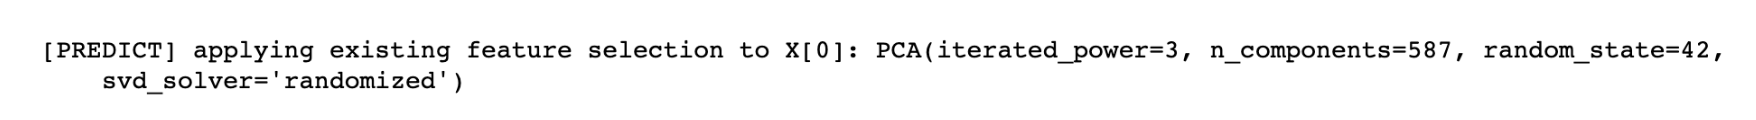

The results you obtain a tiny amount better, because using the 2,000 topics with ridge regression also is a very solid choice.

|            | before dim reduction | after dim reduction |
|------------|----------------------|---------------------|
|**Pearson** |0.6238                | 0.6252             |
|**Spearman**|0.6780                | 0.6807              |

We can add the feature selection pipeline to the gender classification as well.

In [ ]:
database = 'dla_tutorial'
msgs_table = 'msgs'
outcomes_table = 'outcomes'
feat_topics_user = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'

OUTPUT_FOLDER = './output_tutorial_14'
OUTPUT_NAME = 'topics_gender_lr_ms'

!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --outcome_table {outcomes_table} \
    --outcomes gender  \
    --group_freq_thresh 500 \
    --feat_table '{feat_topics_user}' \
    --feature_selection pca \
    --nfold_test_classifiers --model lr --folds 10 --csv \
    --output_name {OUTPUT_FOLDER}/{OUTPUT_NAME} > {OUTPUT_FOLDER}/{OUTPUT_NAME}_logs.txt

The performance has reduced by tiny bit.

|             | before dim reduction | after dim reduction |
|-------------|----------------------|---------------------|
|**acc**      | 0.747                | 0.731               |
|**precision**| 0.748                | 0.731               |
|**recall**   | 0.747                | 0.731               |
|**f1**       | 0.747                | 0.731               |


💡 Selecting the right features (such as topics) is often more important than many dimensionality reduction tricks, but the dimensionality reduction can really help when your sample is small (say a few hundred examples, where you'd also want to cross-validate to 5 folds).

## 5) Considering case frequency and class balance in classification

**Understanding class balance is really important.** If we are trying to do 0/1 classification, we need to consider class balance. For example, if 5% of the people have technology as their occupation, it means that 95% of the people are not working in technology. If we are trying to predict technology-or-not with machine learning, an algorithm that says not-technology all the time is correct 95% of the time. That is hard to beat. It is often impossible to improve on that baseline. That's also why reporting "accuracy" in that case is really misleading: such a trivial decision rule would be 95% accurate.

Let's take a stab in the dark and try to predict occupations:
(note we are using the `--categories_to_binary` flag here to make the binary prediction targets on the fly)

In [ ]:
database = 'dla_tutorial'
msgs_table = 'msgs'
outcomes_table = 'outcomes'
feat_topics_user = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'

OUTPUT_FOLDER = './output_tutorial_14'
OUTPUT_NAME = 'topics_occu_lr'

!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --outcome_table {outcomes_table} \
    --outcomes occu  \
    --categories_to_binary occu \
    --group_freq_thresh 500 \
    --feat_table '{feat_topics_user}' \
    --nfold_test_classifiers --model lr --folds 10 --csv \
    --output_name {OUTPUT_FOLDER}/{OUTPUT_NAME} > {OUTPUT_FOLDER}/{OUTPUT_NAME}_logs.txt

🚨❓ That didn't work!! Do you have a sense why not? -- some of these professions are very rare in our dataset. When we are trying to split 2 accountants across 10 folds, we don't get a sufficient number of accounts in a given testing fold for any machine learning to make sense.

So let's back up, and start by looking at the frequency of the occupations:

In [ ]:
outcomes_table = 'outcomes'

In [ ]:
%%sql

SELECT COUNT(*), occu
FROM {{outcomes_table}}
GROUP BY occu;

Most of them are very infrequent. Let's just try to predict if somebody is a `Student` (N = 275) out of the 1,000. We can make an `is_student` dummy column in the outcome table to help us here.

In [ ]:
%%sql

ALTER TABLE {{outcomes_table}} DROP COLUMN is_student;
ALTER TABLE {{outcomes_table}} ADD COLUMN is_student INTEGER;

UPDATE {{outcomes_table}}
SET is_student =
    CASE
        WHEN is_indunk = 1 THEN NULL
        WHEN occu LIKE 'student' THEN 1
        ELSE 0
    END;

Running query in 'sqlite:///sqlite_data/dla_tutorial.db?charset=utf8mb4'

1000 rows affected.

++
||
++
++

So let's just try to predict is_student or not. Let's further modify our DLATK classification command by:
* adding `--stratify_folds` to the command, which ensures that the same number of students (`is_student` = 1) are in the folds, rather than randomly drawing say 100 users into 10 folds and hoping that we have an adequate number of technology people in there.
* lowering the number of folds to 5

In [ ]:
database = 'dla_tutorial'
msgs_table = 'msgs'
outcomes_table = 'outcomes'
feat_topics_user = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'

OUTPUT_FOLDER = './output_tutorial_14'
OUTPUT_NAME = 'topics_occu_lr'

!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --outcome_table {outcomes_table} \
    --outcomes is_student  \
    --group_freq_thresh 500 \
    --feat_table '{feat_topics_user}' \
    --nfold_test_classifiers --model lr --stratify_folds --folds 5 --csv \
    --output_name {OUTPUT_FOLDER}/{OUTPUT_NAME}

In [ ]:
# if you want to check out the output file in Colab!
csv_format_helper('./output_tutorial_14/topics_occu_lr.accuracy_data.csv')

So this ran through without a hitch, note the final accuracy: .716.

**The AUC value is independent of class balance / MFC accuracy, and often the better metric to compare between tasks.** Rule of thumb for interpretations of AUC in letter grades:
* .9+ A
* .8+ B
* .7+ C <== .7 is often considered "minimal diagnosticity" in medical contexts
* .6+ C--
* .5 <== chance

For comparison, all AUCs associated with trying to predict depression from social media hover around AUC = .70. So an AUC of .75 suggests that some language prediction was possible. Also note the `'folds_se_auc': 0.02`, which gives us the standard error of AUCs across the folds. So roughly, a 95% CI would be given by AUC = .75 [.73, .77].

### 5.1) Balancing classes

What people end up doing frequently in these imbalanced cases is to create a synthetic dataset, where you balance your sample: take 50% technology say, and balance them with 50% non-technology. Now try to run the classification again.

We will do a version of this: We will shortlist the outcome table to only users who are either `Technology` or `indUnk`, that is, have unknown occupations.

💡🤓 We can cleverly do this by giving DLATK a SQL `WHERE` clause that it applies to the outcome table before it runs everything. We do this with a `--where` flag: `'--where "occu LIKE 'Technology' or occu LIKE 'indUnk'"`.

In this application, we can stick with the `--categories_to_binary` switch to generate the binary technology or indUnk outcomes.

In [ ]:
database = 'dla_tutorial'
msgs_table = 'msgs'
outcomes_table = 'outcomes'
feat_topics_user = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'

OUTPUT_FOLDER = './output_tutorial_14'
OUTPUT_NAME = 'topics_occu_lr'

!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --outcome_table {outcomes_table} \
    --group_freq_thresh 500 \
    --feat_table '{feat_topics_user}' \
    --nfold_test_classifiers --model lr --csv --folds 10 \
    --where "occu LIKE 'Technology' or occu LIKE 'indUnk'" \
    --outcomes occu \
    --categories_to_binary occu \
    --output_name {OUTPUT_FOLDER}/{OUTPUT_NAME}

The first thing is to note in the output that we were now using 400 users (`number of groups: 400 (10 Folds)`. Technology vs. industry-Unknown split 13% to 87% (as you can tell from `(mfc_acc: 0.870)` -- so that's very unbalanced. But the accuracy is competetive to the most frequent class accuracy (.863 vs .870), for a good AUC of 0.753.

## 6) There is just no language signal

Finally, predictions will also not work if there is simply no language signal for the outcome of interest -- say for astrology. You will see that predicting star signs works terribly, for that reason:

Let's run it with 5 folds so it runs a little quicker:

In [ ]:
database = 'dla_tutorial'
msgs_table = 'msgs'
outcomes_table = 'outcomes'
feat_topics_user = 'feat$cat_fb2000_cp_w$msgs$user_id$1gra'

OUTPUT_FOLDER = './output_tutorial_14'
OUTPUT_NAME = 'topics_sign_lr'

!mkdir -p {OUTPUT_FOLDER}
!rm -rf {OUTPUT_FOLDER}/{OUTPUT_NAME}*

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field user_id \
    --outcome_table {outcomes_table} \
    --outcomes sign \
    --categories_to_binary sign \
    --group_freq_thresh 500 \
    --feat_table '{feat_topics_user}' \
    --nfold_test_classifiers --model lr --folds 5 --csv \
    --output_name {OUTPUT_FOLDER}/{OUTPUT_NAME}

At the bottom of the output,

* all accuracies hover around / are slightly lower than the MFC accuracies (not suprising the imbalance for predicting say taurus-vs-notTaurus), but
* now the AUCs are also near .50 -- what we would expect by chance. Negative AUCs means that it predicted worse than chance.

In other words, it doesn't seem like there is star sign variance in language that we could exploit to predict it. As you may remember, differential language analyses pointed to a similar conclusion. The one exception might be Pisces and Leos: these star signs notoriously like to talk about being... Pisces and Leos. But you may investigate in future work. (Particularly if you are  Pisces or a Leo 😜).

## 8) Beyond ridge regression and logistic regression

Of course, there are other machine learning algorithms you could run, rather than `--model ridgecv` or `--model lr`.  
For example, a completely different approch is "decision trees", which, when we put a lot of them together to make the prediction more robust, we call "random trees" or "random forests."  Please check out [this excellent visualization](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/) to give you an intuition.

Here are other switches in DLATK you can play around with for different prediction methods.

**Regression (continuous variable)**  
(listed in order to what usually works best)
* Ridge with feature reduction secret sauce (`--model "ridgecv" --feature_select "magic sauce"`)
* LASSO L1 regression `--model "lassocv"` (with no separate feature selection) -- will set the least informative feature coefficietns to 0
* ElasticNet regression `--model elasticnetcv` -- combines LASSO logic with ridge penalty

**Classification (dichotomous variable)**
* L1 linear-svm (`--model "linear-svc"`)
* L1 logistic regression (`--model "lr"`)
* Extremely randomized trees (`--model "etc"`)

You now know the basics of using text-based machine learning for regression and classfication.  
A good day indeed   ¯\\\_(ツ)\_/¯

## 9) Message-level classification of the emotion label

In this section, we familiarize ourselves with the DLATK commands for Machine Learning using the `svitlana` dataset. Here we will use language features of a message to classify if the emotion expressed is `anger` or not.

But before that let's get the `svitlana.db` database file from Google Drive and set up the %sql connection :-)

In [ ]:
database = 'svitlana'

In [ ]:
# Mount Google Drive & copy to Colab

# connects & mounts your Google Drive to this colab space
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# this copies {database}.db from your Google Drive to Colab
!cp -f "/content/drive/MyDrive/sqlite_databases/{database}.db" "sqlite_data"

Mounted at /content/drive


Now to reload the %sql connection and connect a new `svitlana` database engine!

In [ ]:
%reload_ext sql

svitlana_engine = create_engine(f"sqlite:///sqlite_data/{database}.db?charset=utf8mb4")

In [ ]:
# activate to svitlana engine!
%sql svitlana_engine

# set the output limit to 50
%config SqlMagic.displaylimit = 50

Now that we have the dataset, we will create a binary outcome `isAnger` that is set to `1` if a message has expressed anger, and `0` otherwise. Before we do that let's also check the proportion of every emotion in the dataset.

In [ ]:
%%sql

SELECT emotion, COUNT(*) AS freq, (COUNT(*) *1.0 / (SELECT COUNT(*) *1.0 FROM svitlana_outcomes)) AS rel_freq
FROM svitlana_outcomes
GROUP BY emotion
ORDER BY freq DESC;

Running query in 'sqlite:///sqlite_data/svitlana.db?charset=utf8mb4'

emotion,freq,rel_freq
disgust,9967,0.3445688999516006
joy,5449,0.1883772384705801
fear,4879,0.16867178317084974
surprise,4676,0.16165387540620896
anger,2168,0.07494987208739542
sadness,1787,0.06177833091336514


So, we see that `anger` is only `7.5%` of the dataset. When we binarize the message outcome as mentioned above, only `7.5%` will be `1`s and the rest `0`s. There's clear class imbalance here that the model needs to take care of.

However, let's create the binary outcome before we continue.

In [ ]:
outcomes_table = 'svitlana_outcomes'

In [ ]:
%%sql

ALTER TABLE {{outcomes_table}} ADD COLUMN isAnger INT DEFAULT 0;
UPDATE {{outcomes_table}} SET isAnger=1 WHERE emotion = 'anger';

Running query in 'sqlite:///sqlite_data/svitlana.db?charset=utf8mb4'

2168 rows affected.

++
||
++
++

In [ ]:
%%sql

SELECT *
FROM {{outcomes_table}}
ORDER BY RANDOM()
LIMIT 10;

Running query in 'sqlite:///sqlite_data/svitlana.db?charset=utf8mb4'

message_id,emotion,isAnger
21616,disgust,0
28425,anger,1
12447,fear,0
2396,joy,0
7936,surprise,0
28744,anger,1
15823,fear,0
12703,fear,0
21278,disgust,0
2162,joy,0


Now the outcome table is prepare, let's extract message level 1grams.

In [ ]:
database='svitlana'
msgs_table='svitlana_msgs'

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --correl_field message_id \
    --group_freq_thresh 0 \
    --add_ngrams -n 1

And also extract the topic features from the FB 500 topics lexica.

In [ ]:
database =  'svitlana'
lexicondb = 'dlatk_lexica'
msgs_table = 'svitlana_msgs'
topics_cp_table = 'fb22_all_500t_cp'

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --lexicondb {lexicondb} \
    --correl_field message_id \
    --group_freq_thresh 0 \
    --add_lex_table -l {topics_cp_table} \
    --weighted_lexicon

Finally we run 10 fold cross validated logistic regression classifier against `isAnger` using these topic features. Remember to set the `--group_freq_thresh` to `0` because we need to classify every message.

In [ ]:
database =  'svitlana'
lexicondb = 'dlatk_lexica'
msgs_table = 'svitlana_msgs'
outcomes_table = 'svitlana_outcomes'

feat_topics_table = 'feat$cat_fb22_all_500t_cp_w$svitlana_msgs$message_id$1gra'

OUTPUT_FOLDER = './output_tutorial_14'
OUTPUT_NAME = 'topics_anger_lr'

!mkdir -p {OUTPUT_FOLDER}

In [ ]:
!dlatkInterface.py \
    --corpdb {database} \
    --corptable {msgs_table} \
    --lexicondb {lexicondb} \
    --correl_field message_id \
    --outcome_table {outcomes_table} \
    --outcomes isAnger \
    --group_freq_thresh 0 \
    --feat_table '{feat_topics_table}' \
    --nfold_test_classifiers --model lr --folds 10 --csv \
    --output_name {OUTPUT_FOLDER}/{OUTPUT_NAME}

With the class imbalance, how well did we do?

Though the accuracy is `0.954` we know enough to say that it's not the right measure to validate the model. However, the AUC is `0.94`, which is really good (A). So, we'll pat on our backs saying we did a good job 😬.

## ‼️ **Save your database and/or output files** ‼️

Let's save this new database into as a database file in your GDrive `sqlite_databases` folder!

First **`dla_tutorial`**!

In [ ]:
database = 'dla_tutorial'

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# copy the database file to your Drive
!cp -f "sqlite_data/{database}.db" "/content/drive/MyDrive/sqlite_databases/"

print(f"✅ Database '{database}.db' has been copied to your Google Drive.")

Second **`svitlana`**.

In [ ]:
database = 'svitlana'

In [ ]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# copy the database file to your Drive
!cp -f "sqlite_data/{database}.db" "/content/drive/MyDrive/sqlite_databases/"

print(f"✅ Database '{database}.db' has been copied to your Google Drive.")

Mounted at /content/drive
✅ Database 'svitlana.db' has been copied to your Google Drive.


Now let's save the output in this tutorial! Here's how you can save it to your Drive (if you want to)!

In [ ]:
OUTPUT_FOLDER = './output_tutorial_14'

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Copy the database file to your Drive (-r makes it copy the folder and all files/folders inside)
!cp -f -r {OUTPUT_FOLDER} "/content/drive/MyDrive/"

print(f"✅ '{OUTPUT_FOLDER}' has been copied to your Google Drive.")

A good day indeed  ¯\\\_(ツ)_/¯